## Connect MySQL

In [1]:
import json
import mysql.connector
import getpass

with open('config.json') as f:
    config = json.load(f)

host_name = config['host']
user_name = config['user']
passwd = getpass.getpass(prompt='Enter your password: ')

## Dump data from csv to DB

In [2]:
import pandas as pd

cnx = mysql.connector.connect(user=user_name, password=passwd, host=host_name)

cursor = cnx.cursor()
cursor.execute("DROP DATABASE IF EXISTS DB_wine")
cursor.execute("CREATE DATABASE IF NOT EXISTS DB_wine")
cursor.execute("USE DB_wine")

# Define the table name and columns
table_name = 'wine'
header = ['Class', 'Alcohol', 'Malicacid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', '0D280_0D315_of_diluted_wines', 'Proline']  # wine-data
# header = ['Sepal_length', 'Sepal_width', 'Petal_length', 'Petal_width', 'Class']  # iris-data
# header = ['Area', 'Perimeter', 'Major_axis_length', 'Minor_axis_length', 'Aspect_ration', 'Eccentricity', 'Convex_area', 'Equiv_diameter', 'Extent', 'Solidity', 'Roundness', 'Compactness', 'Shape_factor_1', 'Shape_factor_2', 'Shape_factor_3', 'Shape_factor_4', 'Class']  # dry-bean-data
columns = ', '.join([f"`{column}` VARCHAR(255)" for column in header])

# Create the table
create_table_query = f"CREATE TABLE `{table_name}` ({columns}) ENGINE=InnoDB"
cursor.execute(create_table_query)

csv_path = config['csv_path']
df = pd.read_csv(csv_path)

# Insert the data into the table
for _, row in df.iterrows():
    values = ", ".join([f"'{str(value)}'" for value in row])
    insert_query = f"INSERT INTO `{table_name}` VALUES ({values})"
    cursor.execute(insert_query)

# Commit the changes and close the connection
cnx.commit()


## Select data into DataFrame

In [3]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Execute a SELECT query to fetch data from the table
select_query = f"SELECT * FROM wine"
cursor.execute(select_query)

# Fetch all the rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [column[0] for column in cursor.description]

# Convert the fetched data into a pandas DataFrame
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
cnx.close()

# Print the DataFrame
print(df)

    Class Alcohol Malicacid   Ash Alcalinity_of_ash Magnesium Total_phenols   
0     1.0    13.2      1.78  2.14              11.2     100.0          2.65  \
1     1.0   13.16      2.36  2.67              18.6     101.0           2.8   
2     1.0   14.37      1.95   2.5              16.8     113.0          3.85   
3     1.0   13.24      2.59  2.87              21.0     118.0           2.8   
4     1.0    14.2      1.76  2.45              15.2     112.0          3.27   
..    ...     ...       ...   ...               ...       ...           ...   
172   3.0   13.71      5.65  2.45              20.5      95.0          1.68   
173   3.0    13.4      3.91  2.48              23.0     102.0           1.8   
174   3.0   13.27      4.28  2.26              20.0     120.0          1.59   
175   3.0   13.17      2.59  2.37              20.0     120.0          1.65   
176   3.0   14.13       4.1  2.74              24.5      96.0          2.05   

    Flavanoids Nonflavanoid_phenols Proanthocyanins

## Run PCA

Explained Variance Ratio: [99.8107425745665, 0.171938802459895, 0.009494015060618364]
Cumulative Explained Variance Ratio: [99.81074257 99.98268138 99.99217539]


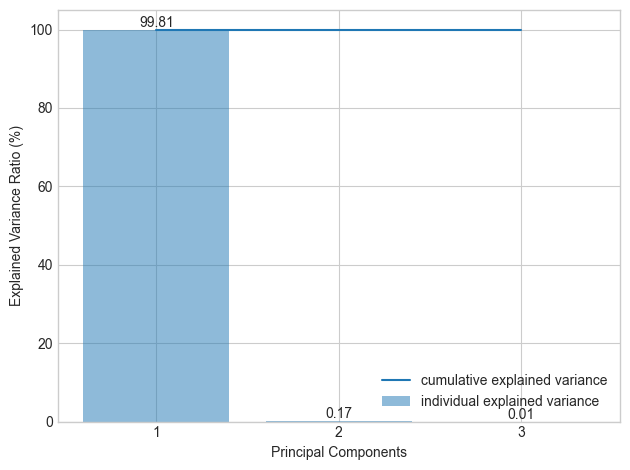

In [4]:
# PCA analysis
n_components = 3
pca = PCA(n_components)  # specify dimensions for PCA
class_var = df['Class']
features = df.drop('Class', axis=1)  # Exclude the target variable 'Class' from the trait
pca_result = pca.fit_transform(features)

# Convert categorical variables to numerical representations
label_encoder = LabelEncoder()
class_encoded = label_encoder.fit_transform(class_var)

# explained variance ratio
ind_var = [i*100 for i in sorted(pca.explained_variance_ratio_, reverse=True)]

# cumulative explained variance ratio
cum_var = np.cumsum(ind_var)
print('Explained Variance Ratio:', ind_var)
print('Cumulative Explained Variance Ratio:', cum_var)

# plot the explained variance ratio
with plt.style.context('seaborn-whitegrid'):
    plt.bar(range(n_components), ind_var, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(n_components), cum_var, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained Variance Ratio (%)')
    plt.xlabel('Principal Components')
    plt.xticks(range(n_components), range(1, n_components+1))
    plt.legend(loc='best')

    for i, v in enumerate(ind_var):
        plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## Plot Scatter Matrix

          PC1        PC2       PC3  Class
0  304.898866  -5.139198  6.845472      0
1  439.863485  -6.239584 -1.085021      0
2  735.039781   0.605870 -0.858411      0
3   -9.778966  18.608535 -0.492842      0
4  705.030955   0.065444  1.007589      0


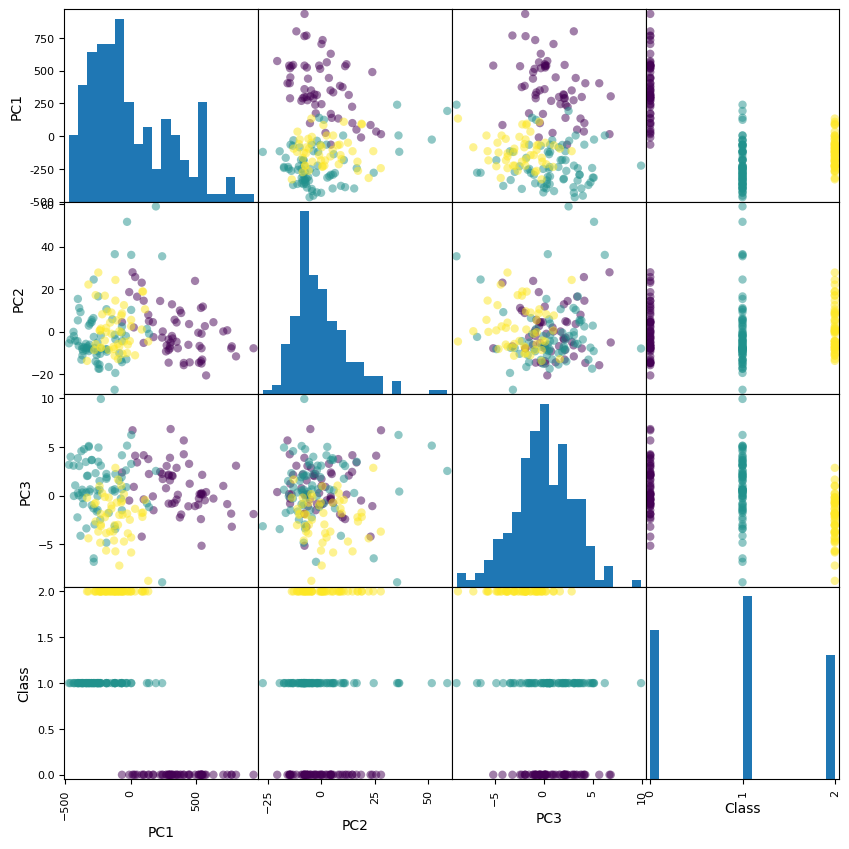

In [5]:
# Create DataFrame with principal components
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
df_pca['Class'] = class_encoded

print(df_pca.head())

# Plot visualization charts using scatter matrix
pd.plotting.scatter_matrix(df_pca, c=df_pca['Class'], figsize=(10, 10), marker='o', hist_kwds={'bins': 20})
plt.show()